<a href="https://colab.research.google.com/github/leinaxd/Portfolio/blob/main/machine_learning/AdversarialTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ADVERSARIAL TRAINING
```
Author: Eichenbaum Daniel
Email: eichenbaum.daniel@gmail.com
```

This is a practical demo for understanding the theory behind: 
  ```
  Chapter: 7.13 Adversarial training

  Goodellow and Bengio, 
  Deep Learning, MIT Press, 2016
  http://www.deeplearningbook.org
  ```

Sources:
  - Adversarial Training

  https://github.com/ndb796/Pytorch-Adversarial-Training-CIFAR

  - Deep dream github

  https://github.com/gordicaleksa/pytorch-deepdream/blob/master/deepdream.py

In [ ]:
import torch, torchvision
from torch import nn, optim
from torch.nn import functional as F

import matplotlib.pyplot as plt
import numpy as np

DOWNLOAD CIFAR DATASET

100%|██████████| 170498071/170498071 [00:12<00:00, 13148555.69it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


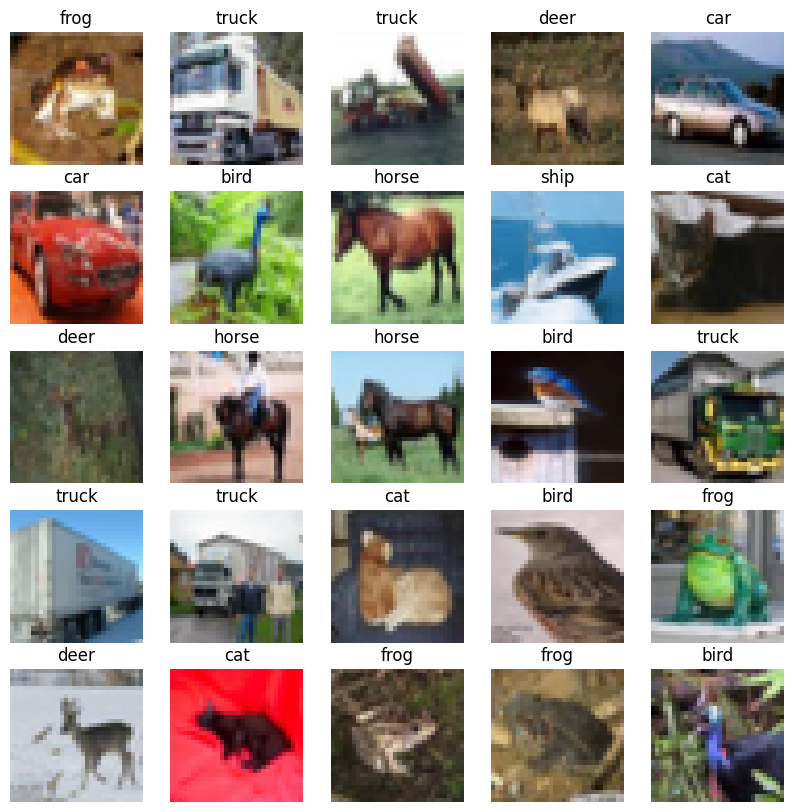

In [ ]:
from torchvision.datasets import CIFAR10
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.transforms import RandomCrop, RandomHorizontalFlip
from torch.utils.data import DataLoader
#@markdown CIFAR 10 Dataset
BATCH_SIZE = 32 
DATASET_AUGMENTATION = False #@param{'type':'boolean'}
show_dataset = True #@param {'type':'boolean'}

transform_train = Compose([
    RandomCrop(32, padding=4),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform_test = Compose([
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

if not DATASET_AUGMENTATION: transform_train = transform_test

transform   = Compose( [ToTensor(),
                        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set    = CIFAR10(root="./data", train=True, download=True, transform=transform_train)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

test_set     = CIFAR10(root="./data", train=False, download=True, transform=transform_test)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

CLASS_NAMES = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")


#Visualize Data
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        img = image_batch[n] / 2 + 0.5     # unnormalize
        img = img.numpy()
        plt.imshow(np.transpose(img, (1, 2, 0)))
        plt.title(label_batch[n])
        plt.axis("off")
sample_images, sample_labels = next(iter(train_loader))
sample_labels = [CLASS_NAMES[label] for label in sample_labels]
if show_dataset:
    show_batch(sample_images, sample_labels)

MODEL
```
Sources:
    - [ConvFF] https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
    - [resnet not implemented] https://pytorch.org/vision/stable/models/resnet.html
```

In [ ]:
class ConvFF(nn.Module):
    def __init__(self, input_shape=(3,32,32), output_size=10, pDropout=0.25):
        super().__init__()
        hidden_size  = 512
        self.dropout = nn.Dropout(pDropout)
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
    
        self.pool     = nn.MaxPool2d(2,2)
        self.flatten  = nn.Flatten()
        self.relu     = nn.ReLU(True)

        self.conv_out_size = self._get_conv_output(input_shape)
        self.ff1 = nn.Linear(self.conv_out_size, hidden_size)
        self.ff2 = nn.Linear(hidden_size, output_size)
        
        # self.loss_criterion = nn.CrossEntropyLoss()
        self.loss_criterion = nn.CrossEntropyLoss(reduction='none')
    def _get_conv_output(self, shape):
        """Feedfoward para saber la dimensión de la convolucional"""
        batch_size = 1
        input = torch.rand(batch_size, *shape)
        output_conv = self.forward_conv(input)
        return output_conv.size(1)

    def forward_conv(self, x):
        x = self.pool(self.relu(self.conv1(x))) #Conv1
        x = self.pool(self.relu(self.conv2(x))) #Conv2
        x = self.pool(self.relu(self.conv3(x))) #Conv3
        x = self.flatten(x)
        x = self.dropout(x)
        return x 

    def forward(self, x):
        x = self.forward_conv(x)
        x = self.dropout(self.relu(self.ff1(x)))
        x = self.ff2(x)
        return x #(nBatch x nClases)

    def loss(self, data, tgt):
        prediction = self(data)
        loss = self.loss_criterion(prediction, tgt)
        loss = loss.mean()
        return loss, prediction

    def predict(self, data):
        """returns (logprob, prediction)"""
        return self.forward(data).max(1) #(nBatch)

 
show_params=True #@param {'type':'boolean'}
if show_params:
    model = ConvFF()
    total_params = sum(p.numel() for p in model.parameters())
    print(f"{total_params:,} total parameters.")
    total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{total_trainable_params:,} trainable parameters.")
    model

361,034 total parameters.
361,034 trainable parameters.


TRAIN RAW MODEL

In [ ]:
from torch.optim import SGD
# Learning and training parameters.
EPOCHS = 50 #@param [10, 20, 50]
EPOCHS = int(EPOCHS)
BATCH_SIZE = "32" #@param [8, 16, 32, 64]
BATCH_SIZE = int(BATCH_SIZE)
LEARNING_RATE = 0.01 #@param [0.01]
LEARNING_RATE = float(LEARNING_RATE)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Epochs: {EPOCHS}")
print(f"Batch_size: {BATCH_SIZE}")
print(f"Learning_rate: {LEARNING_RATE}")
print(f"Device: {device}")

# Model
model_1 = ConvFF()
model_1 = model.to(device)

# Optimizer.
optim = SGD(model.parameters(), lr=LEARNING_RATE)

#Run Training Loop
hist = {}
hist['train_loss'] = []
hist['train_acc'] = []
hist['test_loss'] = []
hist['test_acc'] = []

for epoch in range(EPOCHS):
    model_1.train()
    nSamples = 0
    train_loss = 0
    train_correct = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        loss, output = model_1.loss(data, target)
        optim.zero_grad()
        loss.backward() #calc grad
        optim.step() #update

        train_loss  += loss.item()
        scores, predicted = output.max(1)
        nSamples   += data.size(0)
        train_correct += predicted.eq(target).sum().item()
    
    train_loss = train_loss/nSamples
    train_accuracy = train_correct / nSamples
    hist['train_loss'].append(train_loss)
    hist['train_acc'].append(train_accuracy)
    print(f"{epoch}: train_Loss: {train_loss:.3}, Accuracy: {train_accuracy:.3}",end=' | ')

    model_1.eval()
    nSamples = 0
    test_loss = 0
    test_correct = 0

    example_images = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)           
            loss, output = model_1.loss(data, target)
            test_loss += loss.item()
            scores, predicted = output.max(1)
            nSamples += data.size(0)
            test_correct += predicted.eq(target).sum().item()

    test_accuracy = test_correct / nSamples
    test_loss     = test_loss / nSamples
    hist['test_loss'].append(test_loss)
    hist['test_acc'].append(test_accuracy)
    print(f"test_loss: {test_loss:.3}, test_accuracy: {test_accuracy:.3}")

print("Finished Training")

In [ ]:
torch.save(model.state_dict(), 'ConvFF.torch')

In [ ]:
model = ConvFF()
model.load_state_dict(torch.load('ConvFF.torch'))

In [ ]:
fig1, (ax1,ax2) = plt.subplots(1,2)
fig2, (ax3,ax4) = plt.subplots(1,2)

ax1.plot(hist['train_loss'])
ax2.plot(hist['test_loss'])
ax3.plot(hist['train_acc'])
ax4.plot(hist['test_acc'])
ax1.set_title('train_loss')
ax2.set_title('test_loss')
ax3.set_title('train_accuracy')
ax4.set_title('test_accuracy');

Now we have our classifier, we can think about attacking the model with adversarial samples.

In [ ]:
class adversarial_sampling:
    """
    Finds a perturbation (\epsilon) for the sample x which confuses the network in an adversarial behaviour

    x_adv = x + epsilon
    
    if you repeat <nSteps>, then your perturbation will be in a ball contained
        x_adv  \in  B(x, epsilon*nSteps)
    in other words:
        |x_adv - x|_p < epsilon*nSteps

    Features:
        - Virtual Adversarial Training
              Miyato et all 2015
    Method
    1. Include the gradient at the input tensor
    2. Compute regular loss
    3. Backpropagate
    4. Update the adversarial input in the increasing direction (+gradient)
        x_adv = x + \epsilon
              = x + \epsilon sign(dloss/dx)
    5. Repeat for K steps

    sources:
        https://github.com/ndb796/Pytorch-Adversarial-Training-CIFAR

        Goodfellow himself explaining adversarial examples
        https://www.youtube.com/watch?v=CIfsB_EYsVI
    Note. if alpha is negative, then you are finding an image who is reinforcing your belief 
          a similar approach is found in google deep dream
    """
    def __init__(self, model, epsilon=0.01, nSteps=7, w_init=0.01, virtual_training=False):
        self.model = model
        self.nSteps = nSteps
        self.epsilon = epsilon
        self.w_init = w_init
        self.virtual_training = virtual_training
    def sample(self, x, tgt=None):
        x = x.detach()
        if self.virtual_training:
            _, tgt = self.model.predict(x)
            tgt = tgt.detach()

        x_adv = x + torch.zeros_like(x).uniform_(-self.w_init, self.w_init)
        for i in range(self.nSteps):
            x_adv.requires_grad_()
            with torch.enable_grad():                    
                loss, output = self.model.loss(x_adv, tgt)
            grad = torch.autograd.grad(loss, [x_adv]) [0]
            x_adv, grad = x_adv.detach(), grad.detach()
            x_adv = x_adv + self.epsilon * torch.sign(grad) #Wnew = wold - alpha grad
            # do you want to clamp the image in a defined radius?
            #     -1 < x-epsilon < x_adv < x + epsilon < 1
            # x_adv = torch.clamp(x_adv, x-self.w_init, x+self.w_init) 
            x_adv = torch.clamp(x_adv, -1, 1)
        return x_adv

In [ ]:
model = model_1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device);

Model Prediction
Adversarial Prediction


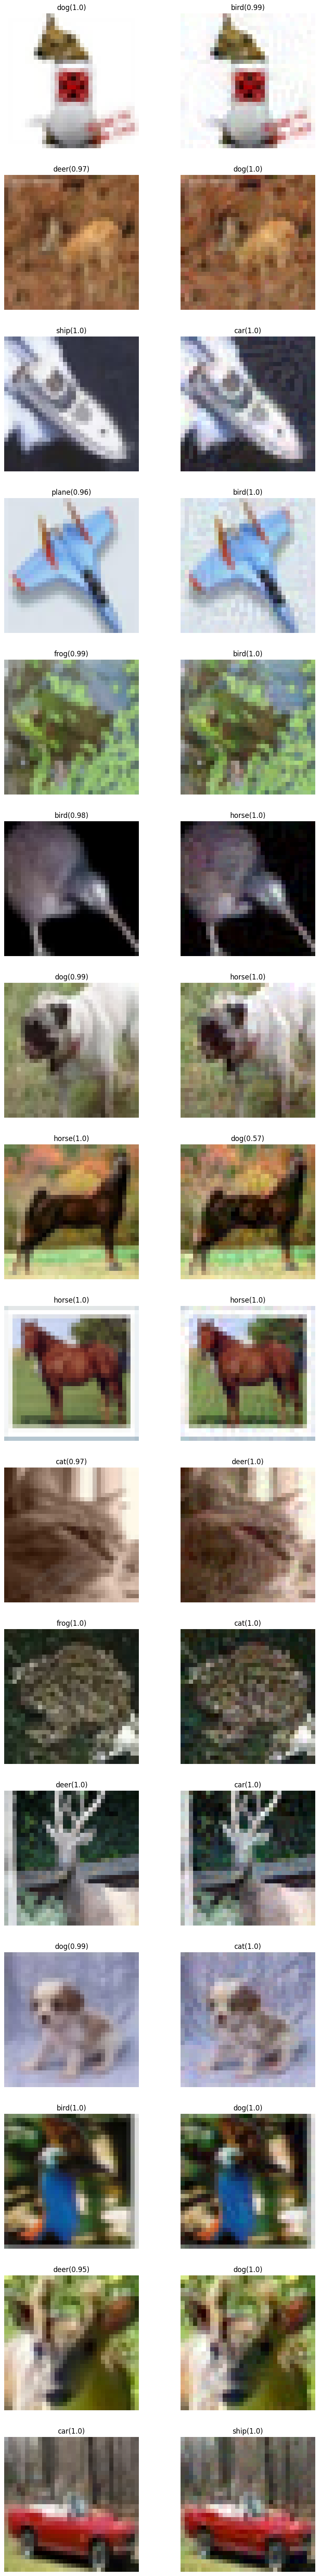

In [ ]:
#@markdown Play with Adversely generated Images 
w_init = 0.001 #@param {'type':'number'}
epsilon = 0.01 #@param {'type':'number'}
nSteps = 10 #@param {'type':'integer'}
virtual_training=False #@param {'type':'boolean'}
random_input=False #@param {'type':'boolean'}

#Visualize Data
adv = adversarial_sampling(model, nSteps=nSteps, epsilon=epsilon, w_init=w_init, virtual_training=virtual_training)
img, labels = next(iter(train_loader))
img, labels = img.to(device), labels.to(device)

model.eval()
with torch.no_grad():
    output = model(img)
    output = F.softmax(output,-1)
    probs, predicted = output.max(1)
    predicted = [CLASS_NAMES[label]+f"({prob:.2})" for label, prob in zip(predicted, probs)]
    print('Model Prediction')
    # show_batch(img.cpu(), predicted)
plt.pause(0.01)

adv_img = img
if random_input: adv_img = torch.zeros_like(img).uniform_(-1, 1)

adv_img = adv.sample(adv_img, labels)
with torch.no_grad():
    output = model(adv_img)
    output = F.softmax(output,-1)
    probs, adv_predicted = output.max(1)
    adv_predicted = [CLASS_NAMES[label]+f"({prob:.2})" for label, prob in zip(adv_predicted, probs)]
    print('Adversarial Prediction')
    # show_batch(adv_img.cpu(), adv_predicted)

batch_size = img.size(0)
plt.figure(figsize=(10, batch_size/2*10))

for n in range(0, batch_size, 2):
    ax1 = plt.subplot(batch_size,2,n+1)
    ax2 = plt.subplot(batch_size,2,n+2)
    _img = img[n].cpu() / 2 + 0.5     # unnormalize
    _img = _img.numpy()
    _adv_img = adv_img[n].cpu() /2 +0.5
    _adv_img = _adv_img.numpy()
    ax1.imshow(np.transpose(_img, (1, 2, 0)))
    ax2.imshow(np.transpose(_adv_img, (1, 2, 0)))
    ax1.set_title(predicted[n])
    ax2.set_title(adv_predicted[n])
    ax1.axis("off")
    ax2.axis("off")

In [ ]:
# Applications
#1. defense against pgd attack
#2. Accuracy gain??


ADVERSARIAL TRAINING 
(Input is perturbed before training)


Note. This is just a demo for easy understanding. 
Its INEFICIENT to train 3 models at once. Using seeding allows you to train all models with same data sequence. 

In [ ]:
from torch.optim import SGD
# Model
model_1 = ConvFF().to(device) #normal
model_2 = ConvFF().to(device) #adversarial
model_3 = ConvFF().to(device) #Virtual-adversarial
nSteps=5
w_init=0.001
epsilon =0.01
EPOCHS=200
LEARNING_RATE = 0.01
#Adversarial
adv = adversarial_sampling(model_2, nSteps=nSteps, epsilon=epsilon, w_init=w_init, virtual_training=False)
vadv = adversarial_sampling(model_3, nSteps=nSteps, epsilon=epsilon, w_init=w_init, virtual_training=True)

# Optimizer.
optim_1 = SGD(model_1.parameters(), lr=LEARNING_RATE)
optim_2 = SGD(model_2.parameters(), lr=LEARNING_RATE)
optim_3 = SGD(model_3.parameters(), lr=LEARNING_RATE)

#Run Training Loop
hist = {}
hist['train_loss'] = []
hist['train_loss_adv'] = []
hist['train_loss_vadv'] = []
hist['train_acc'] = []
hist['train_acc_adv'] = []
hist['train_acc_vadv'] = []
hist['test_loss'] = []
hist['test_loss_adv'] = []
hist['test_loss_vadv'] = []
hist['test_acc'] = []
hist['test_acc_adv'] = []
hist['test_acc_vadv'] = []
hist['test_loss_def'] = []
hist['test_loss_def_adv'] = []
hist['test_loss_def_vadv'] = []
hist['test_acc_def'] = []
hist['test_acc_def_adv'] = []
hist['test_acc_def_vadv'] = []
for epoch in range(int(EPOCHS)):
    model_1.train()
    model_2.train()
    model_3.train()

    nSamples = 0
    train_loss_1 = 0
    train_loss_2 = 0
    train_loss_3 = 0
    train_correct_1 = 0
    train_correct_2 = 0
    train_correct_3 = 0

    for input, target in train_loader:
        input, target = input.to(device), target.to(device)
        input_adv  = adv.sample(input, target)#perturbed input
        input_vadv = vadv.sample(input)
        loss_1, output_1 = model_1.loss(input,      target)
        loss_2, output_2 = model_2.loss(input_adv,  target)
        loss_3, output_3 = model_3.loss(input_vadv, target)

        optim_1.zero_grad()
        optim_2.zero_grad()
        optim_3.zero_grad()
        loss_1.backward()
        loss_2.backward()
        loss_3.backward()
        optim_1.step()
        optim_2.step()
        optim_3.step()

        nSamples      += input.size(0)
        train_loss_1  += loss_1.item()
        train_loss_2  += loss_2.item()
        train_loss_3  += loss_3.item()
        scores, predicted_1 = output_1.max(1)
        scores, predicted_2 = output_2.max(1)
        scores, predicted_3 = output_3.max(1)
        train_correct_1 += predicted_1.eq(target).sum().item()
        train_correct_2 += predicted_2.eq(target).sum().item()
        train_correct_3 += predicted_3.eq(target).sum().item()
    
    train_loss_1 = train_loss_1/nSamples
    train_loss_2 = train_loss_2/nSamples
    train_loss_3 = train_loss_3/nSamples
    train_accuracy_1 = train_correct_1 / nSamples
    train_accuracy_2 = train_correct_2 / nSamples
    train_accuracy_3 = train_correct_3 / nSamples
    
    hist['train_loss'].append(train_loss_1)
    hist['train_loss_adv'].append(train_loss_2)
    hist['train_loss_vadv'].append(train_loss_3)
    hist['train_acc'].append(train_accuracy_1)
    hist['train_acc_adv'].append(train_accuracy_2)
    hist['train_acc_vadv'].append(train_accuracy_3)
    print(f"Epoch {epoch}:")
    print(f"\ttrain_loss: {train_loss_1:.3}, accuracy: {train_accuracy_1:.3}")
    print(f"\ttrain_loss_adv: {train_loss_2:.3},  acc_adv: {train_accuracy_2:.3}")
    print(f"\ttrain_loss_vadv: {train_loss_3:.3}, acc_vadv: {train_accuracy_3:.3}")

    model_1.eval()
    model_2.eval()
    model_3.eval()
    nSamples = 0
    test_loss_1 = 0
    test_loss_2 = 0
    test_loss_3 = 0
    test_correct_1 = 0
    test_correct_2 = 0
    test_correct_3 = 0

    test_loss_def_1 = 0
    test_loss_def_2 = 0
    test_loss_def_3 = 0
    test_correct_def_1 = 0
    test_correct_def_2 = 0
    test_correct_def_3 = 0
    with torch.no_grad():
        for input, target in test_loader:
            input, target = input.to(device), target.to(device)           
            input_adv  = adv.sample(input, target)
            input_vadv = vadv.sample(input)
            loss_1, output_1 = model_1.loss(input, target)
            loss_2, output_2 = model_2.loss(input_adv, target)
            loss_3, output_3 = model_3.loss(input_vadv, target)
            
            nSamples += input.size(0)
            test_loss_1 += loss_1.item()
            test_loss_2 += loss_2.item()
            test_loss_3 += loss_3.item()
            _, predicted_1 = output_1.max(1)
            _, predicted_2 = output_2.max(1)
            _, predicted_3 = output_3.max(1)
            test_correct_1 += predicted_1.eq(target).sum().item()
            test_correct_2 += predicted_2.eq(target).sum().item()
            test_correct_3 += predicted_3.eq(target).sum().item()
            
            #Defense accuracy
            def_input = adv.sample(input, target)
            def_loss_1, def_output_1 = model_1.loss(def_input, target)
            def_loss_2, def_output_2 = model_2.loss(def_input, target)
            def_loss_3, def_output_3 = model_3.loss(def_input, target)

            test_loss_def_1 += def_loss_1.item()
            test_loss_def_2 += def_loss_2.item()
            test_loss_def_3 += def_loss_3.item()
            _, def_predicted_1 = def_output_1.max(1)
            _, def_predicted_2 = def_output_2.max(1)
            _, def_predicted_3 = def_output_3.max(1)
            test_correct_def_1 += def_predicted_1.eq(target).sum().item()
            test_correct_def_2 += def_predicted_2.eq(target).sum().item()
            test_correct_def_3 += def_predicted_3.eq(target).sum().item()

    test_loss_1     = test_loss_1 / nSamples
    test_loss_2     = test_loss_2 / nSamples
    test_loss_3     = test_loss_3 / nSamples
    test_accuracy_1 = test_correct_1 / nSamples
    test_accuracy_2 = test_correct_2 / nSamples
    test_accuracy_3 = test_correct_3 / nSamples
    test_loss_def_1 = test_loss_def_1 / nSamples
    test_loss_def_2 = test_loss_def_2 / nSamples
    test_loss_def_3 = test_loss_def_3 / nSamples
    test_accuracy_def_1 = test_correct_def_1 / nSamples
    test_accuracy_def_2 = test_correct_def_2 / nSamples
    test_accuracy_def_3 = test_correct_def_3 / nSamples

    hist['test_loss'].append(test_loss_1)
    hist['test_loss_adv'].append(test_loss_2)
    hist['test_loss_vadv'].append(test_loss_3)
    hist['test_acc'].append(test_accuracy_1)
    hist['test_acc_adv'].append(test_accuracy_2)
    hist['test_acc_vadv'].append(test_accuracy_3)
    hist['test_loss_def'].append(test_loss_def_1)
    hist['test_loss_def_adv'].append(test_loss_def_2)
    hist['test_loss_def_vadv'].append(test_loss_def_3)
    hist['test_acc_def'].append(test_accuracy_def_1)
    hist['test_acc_def_adv'].append(test_accuracy_def_2)
    hist['test_acc_def_vadv'].append(test_accuracy_def_3)
    print(f"\ttest_loss: {test_loss_1:.3}, test_accuracy: {test_accuracy_1:.3}")
    print(f"\ttest_loss_adv: {test_loss_2:.3}, test_accuracy_adv: {test_accuracy_2:.3}")
    print(f"\ttest_loss_vadv: {test_loss_3:.3}, test_accuracy_vadv: {test_accuracy_3:.3}")
    print(f"\ttest_loss_def: {test_loss_def_1:.3}, test_accuracy_def: {test_accuracy_def_1:.3}")
    print(f"\ttest_loss_def_adv: {test_loss_def_2:.3}, test_accuracy_def_adv: {test_accuracy_def_2:.3}")
    print(f"\ttest_loss_def_vadv: {test_loss_def_3:.3}, test_accuracy_def_vadv: {test_accuracy_def_3:.3}")

print("Finished Training")

Epoch 0:
	train_loss: 0.0687, accuracy: 0.185
	train_loss_adv: 0.0712,  acc_adv: 0.12
	train_loss_vadv: 0.0691, acc_vadv: 0.171
	test_loss: 0.0616, test_accuracy: 0.295
	test_loss_adv: 0.0692, test_accuracy_adv: 0.172
	test_loss_vadv: 0.0616, test_accuracy_vadv: 0.276
	test_loss_def: 0.0647, test_accuracy_def: 0.252
	test_loss_def_adv: 0.0692, test_accuracy_def_adv: 0.172
	test_loss_def_vadv: 0.0635, test_accuracy_def_vadv: 0.262
Epoch 1:
	train_loss: 0.058, accuracy: 0.322
	train_loss_adv: 0.0676,  acc_adv: 0.196
	train_loss_vadv: 0.0592, acc_vadv: 0.297
	test_loss: 0.0532, test_accuracy: 0.381
	test_loss_adv: 0.0659, test_accuracy_adv: 0.228
	test_loss_vadv: 0.0557, test_accuracy_vadv: 0.33
	test_loss_def: 0.0613, test_accuracy_def: 0.296
	test_loss_def_adv: 0.0659, test_accuracy_def_adv: 0.228
	test_loss_def_vadv: 0.0598, test_accuracy_def_vadv: 0.312
Epoch 2:
	train_loss: 0.0511, accuracy: 0.402
	train_loss_adv: 0.0647,  acc_adv: 0.237
	train_loss_vadv: 0.0547, acc_vadv: 0.343
	tes

KeyboardInterrupt: ignored

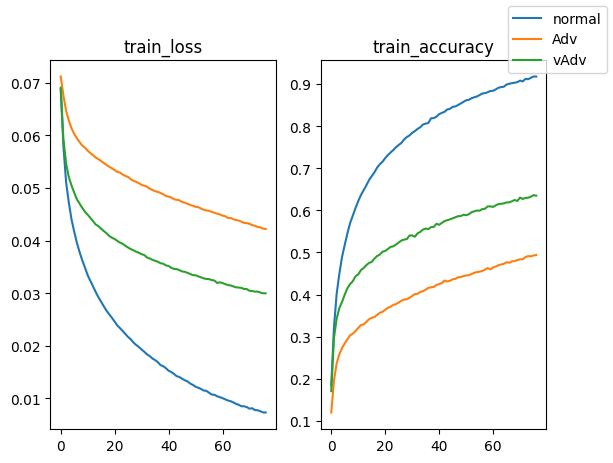

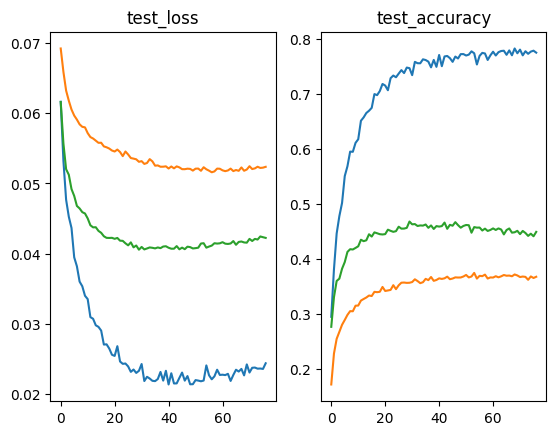

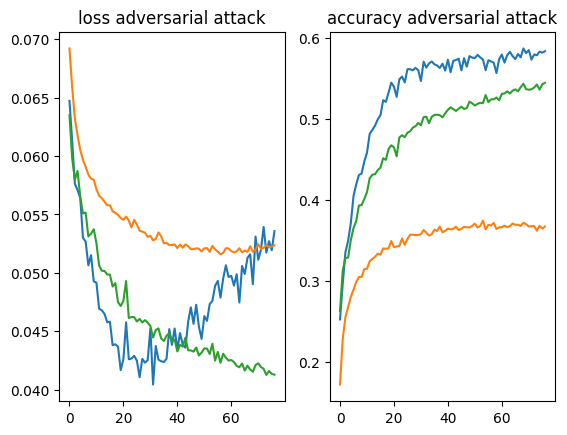

In [ ]:
fig1, (ax1,ax2) = plt.subplots(1,2)
fig2, (ax3,ax4) = plt.subplots(1,2)
fig3, (ax5,ax6) = plt.subplots(1,2)

ax1.plot(hist['train_loss'], label='normal')
ax1.plot(hist['train_loss_adv'], label='Adv')
ax1.plot(hist['train_loss_vadv'], label='vAdv')
ax2.plot(hist['train_acc'])
ax2.plot(hist['train_acc_adv'])
ax2.plot(hist['train_acc_vadv'])

ax3.plot(hist['test_loss'])
ax3.plot(hist['test_loss_adv'])
ax3.plot(hist['test_loss_vadv'])
ax4.plot(hist['test_acc'])
ax4.plot(hist['test_acc_adv'])
ax4.plot(hist['test_acc_vadv'])

ax5.plot(hist['test_loss_def'])
ax5.plot(hist['test_loss_def_adv'])
ax5.plot(hist['test_loss_def_vadv'])
ax6.plot(hist['test_acc_def'])
ax6.plot(hist['test_acc_def_adv'])
ax6.plot(hist['test_acc_def_vadv'])

ax1.set_title('train_loss')
ax2.set_title('train_accuracy')
ax3.set_title('test_loss')
ax4.set_title('test_accuracy');
ax5.set_title('loss adversarial attack')
ax6.set_title('accuracy adversarial attack')
fig1.legend()

CONCLUSIONS:

I didn't found an increase of Accuracy in the Adversarial Training

## BACKUP results

In [1]:
#@markdown BACK UP training evolution loss/acc
for key, value in hist.items():
    print(key)
    print(value)

# train_loss
# [0.06775072035551072, 0.05645259621620178, 0.05109879050970077, 0.04756793496608734, 0.04458353428125381, 0.04207762242436409, 0.03980721864938736, 0.03804085368514061, 0.03647221874475479, 0.03512333626866341, 0.033767337255477904, 0.03253113149523735, 0.03140016623020172, 0.030257743750810622, 0.029397997691631317, 0.028528577144145965, 0.02758676748931408, 0.02669492530763149, 0.02598161877810955, 0.0252789887714386, 0.02462703146994114, 0.02402927634358406, 0.023248972802758217, 0.022744882630109788, 0.02218094353079796, 0.021593125211596488, 0.020940048688948155, 0.020644893422722816, 0.02001682716101408, 0.019547047410309316, 0.019032928506433965, 0.018772782379090785, 0.01822985471069813, 0.017721478008627892, 0.017338829514682293, 0.017016896931827067, 0.016687633769214155, 0.016263704377412796, 0.015791072453260422, 0.015521346828341484, 0.01511352915674448, 0.014770491410791875, 0.014400403801798821, 0.01401684739112854, 0.01394668921545148, 0.01346834684446454, 0.013036899717003107, 0.012948359345495701, 0.012554716785550117, 0.012376263753175736, 0.01204553851187229, 0.011759018372371793, 0.01135492333009839, 0.011243501597642898, 0.011022152590230106, 0.010650398987680674, 0.010685025115460158, 0.010259705377668142, 0.01015867549687624, 0.009813261825889348, 0.009677077883780003, 0.0094508748222515, 0.009147264189347625, 0.009022386145219207, 0.008951455710232257, 0.008717446731552482, 0.008507042335942388, 0.008361722913980484, 0.008143435279205441, 0.008023035389184951, 0.0078264199116081, 0.007658243256211281, 0.007645203362964093, 0.007418924372419715, 0.007283619545698166, 0.007138913514204323, 0.006999640090726316, 0.007013754348084331, 0.006743668910022825, 0.006583598232641816, 0.00665092221558094, 0.006452650687508285, 0.006334458983875811, 0.006232316283658147, 0.006187989313267171, 0.005977169738896191, 0.006005951739996671, 0.005939358286559582, 0.005846713179498911, 0.0056865321688912805, 0.00578129156395793, 0.005471289535239339, 0.005399170523956418, 0.005399374446682632, 0.005434520763866604, 0.005382937945965677, 0.005016008983924985, 0.005111619987292215, 0.005156128855794668, 0.004915020790435373, 0.004936864162813872, 0.004907911557219922, 0.004776583858001977, 0.004665165480300784, 0.00467486559974961, 0.004533318966273218, 0.004672272479049861, 0.004484752559438348, 0.00439790189312771, 0.004428054834548384, 0.0044659338077344, 0.004340437377132475, 0.004198205400733277, 0.004378192152883858, 0.004101729651940987, 0.004174887121785432, 0.004112191512715071, 0.00414415262366645, 0.004101289382944815, 0.004041265297560021, 0.003967312175054103, 0.0040350834189262245, 0.003942692550909705, 0.0038881809305772183, 0.004035197065416723, 0.003836154627595097, 0.003640076095815748, 0.0037298835271783173, 0.0036931918665301057, 0.0037514556982321664, 0.0036080924708861858, 0.0037545483136735857, 0.0035863013764983044, 0.0035961963902134447, 0.003550638191336766, 0.0035781708549661563, 0.003430761356521398, 0.0034168785370886326, 0.0034203909249883144, 0.003454349356377497, 0.003403436393951997, 0.0031833794162236155, 0.0033543068696558474, 0.0035203836295194923, 0.003234690331830643]
# train_loss_adv
# [0.07157712588787078, 0.06843584766626358, 0.06557126826763153, 0.06305310901880264, 0.0614688007235527, 0.06038747867107391, 0.05947033760309219, 0.05881387235879898, 0.05813637147903442, 0.05761082628965378, 0.057102155213356015, 0.056630827362537384, 0.05615752800226211, 0.055788430988788607, 0.05531764580726624, 0.055035562348365784, 0.054646753778457645, 0.05432150046825409, 0.05402342479705811, 0.05365665782213211, 0.05342620568990707, 0.05311389065504074, 0.052791378087997436, 0.052530930099487304, 0.05215973568201065, 0.05190474594354629, 0.05165811398744583, 0.05136360802650452, 0.05113578821897507, 0.05097553715467453, 0.05052779031991959, 0.050365118055343626, 0.05005284331083298, 0.04988487297296524, 0.049623126182556154, 0.04933961535930634, 0.049191767735481264, 0.04896167281627655, 0.04880816865205765, 0.04856215269804001, 0.048249421286582946, 0.04810031765937805, 0.04790351209402084, 0.047729324502944946, 0.04745993177652359, 0.0472728523516655, 0.047196953468322755, 0.0469474904358387, 0.04670401912927628, 0.04658588691949844, 0.04634382858157158, 0.04615132652521133, 0.04594682612299919, 0.04571488417387009, 0.04555385788679123, 0.04541132242798805, 0.04519613111257553, 0.045172282658815385, 0.044857216470241545, 0.04475301761865616, 0.04455591332793236, 0.04428038499116898, 0.04415151327848434, 0.04401914202690124, 0.04385307445168495, 0.043724110847711564, 0.04354208115577698, 0.04343248171567917, 0.04331557684779167, 0.043056954510211944, 0.04288423093557358, 0.04280131386160851, 0.042567211533784864, 0.042395012397766114, 0.04237893101215363, 0.04213307313084602, 0.04193881922960281, 0.04172202164888382, 0.04172139710307121, 0.04145751189827919, 0.04140916133284569, 0.04123186616659164, 0.04110130638241768, 0.040891315743923184, 0.040812033473253254, 0.04059786666154862, 0.040412139171361924, 0.04041466371059418, 0.04021121605873108, 0.04006656804680824, 0.03981933049082756, 0.03989188911437988, 0.03964294966340065, 0.03957834383368492, 0.03951625811100006, 0.039242164117097855, 0.03915798728346825, 0.03899833269715309, 0.03884294211268425, 0.03871771432042122, 0.038509895037412645, 0.03861813337564468, 0.03844689219713211, 0.03820650831103325, 0.03814244117975235, 0.038019478725194934, 0.03773564595580101, 0.03776751531243324, 0.03767789538741112, 0.03761342146873474, 0.037327423261404036, 0.03720749517083168, 0.03724370950698853, 0.03713307786345482, 0.036829097514152524, 0.036772808922529224, 0.03653033264160156, 0.036586220794916156, 0.0364497483253479, 0.03641938215970993, 0.036259954270124434, 0.036019230099916456, 0.03602830124735832, 0.0358127024102211, 0.0357477487885952, 0.03565332880854607, 0.035598766469955447, 0.03550831158041954, 0.03530036686182022, 0.03523166486978531, 0.03519410787224769, 0.035076914578676226, 0.03497530056715012, 0.03488465244293213, 0.03483216934680939, 0.03466392993330956, 0.03455478379368782, 0.03445535392165184, 0.034320498408079145, 0.03439867357730866, 0.03413692934989929, 0.03413042611002922, 0.033970421192646025, 0.033852549372911454, 0.033810809265375136]
# train_loss_vadv
# [0.06748024545669555, 0.058302859227657315, 0.053935881671905515, 0.05158462652921677, 0.049825445630550386, 0.04866576312541962, 0.04763208651781082, 0.04670053017616272, 0.04596577421426773, 0.04512998447775841, 0.04457134426116943, 0.0441011513030529, 0.043670690237283705, 0.04320854269862175, 0.04264876710176468, 0.0422090877699852, 0.04167895362734795, 0.04138078044652939, 0.04097206836462021, 0.04049238508105278, 0.04022273072123528, 0.03999953037381172, 0.03954294804215431, 0.039271996873617175, 0.03901705501914025, 0.038791851050853726, 0.03831523912906647, 0.038063286343812945, 0.037963471491336824, 0.037674862496852875, 0.037239997572898864, 0.037208152726888655, 0.03682384454011917, 0.03656750260353089, 0.03642599189400673, 0.03626825716614723, 0.035984188643693925, 0.03583163820028305, 0.03557702451229095, 0.035317570984363555, 0.03525054509758949, 0.03508510373234749, 0.03467687015533447, 0.034524596371650694, 0.034363269209861755, 0.03417567518115044, 0.03419347332835197, 0.03384850912332535, 0.03352405302286148, 0.033522724903821945, 0.03344607082128525, 0.03311720276594162, 0.03311648516178131, 0.03283613775372505, 0.03267033099591732, 0.0325858372271061, 0.03238345962882042, 0.03226853746592998, 0.03206438691973686, 0.03200551219820976, 0.03190349909901619, 0.03164501563072204, 0.03158187081098557, 0.031370624135732654, 0.03145516453027725, 0.031121588509082795, 0.0311330573874712, 0.030901497342586518, 0.03074292414307594, 0.030695354497432707, 0.030700846729278565, 0.030474312955141067, 0.030166699746847152, 0.03031462234377861, 0.029913250321149824, 0.030059039828777313, 0.03004836437344551, 0.029947317308187484, 0.02962744063615799, 0.02964021659374237, 0.029569946517944336, 0.029327975007891655, 0.029364488201141358, 0.02926938013255596, 0.028993617668151856, 0.029075337030291557, 0.028888412079811097, 0.028982319875955582, 0.028732309416532518, 0.028572291442751883, 0.028507023082375526, 0.02834063981950283, 0.028315704767107965, 0.028313994512557984, 0.028337618438601494, 0.02804819819152355, 0.027926442647576332, 0.02797386421263218, 0.0279754562073946, 0.027858004829883574, 0.027936024718284606, 0.02756103296637535, 0.027725317628979684, 0.02753402562201023, 0.02760577291727066, 0.02747623691856861, 0.027344066478013993, 0.027212209581136702, 0.027349475456476213, 0.027106056554317474, 0.02683360532939434, 0.02702475280404091, 0.027061517614126205, 0.027075790029764176, 0.026892732121944426, 0.02675118241250515, 0.026895095573067664, 0.026848647226691245, 0.026484696382880212, 0.026453050241470336, 0.026435735909342766, 0.02651538484454155, 0.02634934477865696, 0.02627424991965294, 0.026146128177046774, 0.026231353499293328, 0.02599456484913826, 0.026040195459127426, 0.026040368923544884, 0.026040828214287756, 0.026032781129479408, 0.02573933810055256, 0.02577448525428772, 0.025782162250876428, 0.025710854182839395, 0.025818780301213266, 0.02556853885948658, 0.025516098523139952, 0.025491962416172027, 0.025447117629647256, 0.0252858368986845, 0.025375702140927315, 0.025303544631004333, 0.025311553520560266, 0.02524039876639843]
# train_acc
# [0.19234, 0.3344, 0.39892, 0.44236, 0.4834, 0.51468, 0.54302, 0.56504, 0.58572, 0.6018, 0.61782, 0.6336, 0.64684, 0.65866, 0.6701, 0.6784, 0.69258, 0.70198, 0.70894, 0.71648, 0.72382, 0.73098, 0.73972, 0.74456, 0.75232, 0.756, 0.76388, 0.76774, 0.7771, 0.77906, 0.78736, 0.78808, 0.79516, 0.80058, 0.8049, 0.80816, 0.81204, 0.8167, 0.82156, 0.82598, 0.82844, 0.83272, 0.83692, 0.84014, 0.8421, 0.84652, 0.85112, 0.8536, 0.85538, 0.85938, 0.86428, 0.8651, 0.87066, 0.87206, 0.87536, 0.87866, 0.87784, 0.88302, 0.88456, 0.88658, 0.88888, 0.89228, 0.89488, 0.89802, 0.89726, 0.9011, 0.90434, 0.9042, 0.90674, 0.90864, 0.91102, 0.91212, 0.91226, 0.91566, 0.91694, 0.91818, 0.9202, 0.91882, 0.92346, 0.92336, 0.92402, 0.92692, 0.9284, 0.92878, 0.93034, 0.93246, 0.93146, 0.93216, 0.93328, 0.93472, 0.93408, 0.93802, 0.93882, 0.94002, 0.93782, 0.93928, 0.94278, 0.94204, 0.9409, 0.94434, 0.94404, 0.94358, 0.94642, 0.94756, 0.94644, 0.94966, 0.9467, 0.94974, 0.95246, 0.9493, 0.94946, 0.95102, 0.95302, 0.95094, 0.95408, 0.95298, 0.95382, 0.95322, 0.95388, 0.95494, 0.95568, 0.95536, 0.95532, 0.95646, 0.95426, 0.9578, 0.9594, 0.95722, 0.95906, 0.95814, 0.95872, 0.958, 0.96118, 0.95984, 0.96044, 0.96006, 0.96206, 0.96092, 0.96176, 0.96148, 0.96288, 0.96478, 0.96334, 0.9612, 0.9642]
# train_acc_adv
# [0.10354, 0.18222, 0.2257, 0.25382, 0.27162, 0.28236, 0.292, 0.29982, 0.3066, 0.3162, 0.31746, 0.32542, 0.33, 0.33516, 0.34112, 0.34414, 0.34848, 0.35344, 0.35608, 0.36106, 0.36502, 0.36606, 0.37056, 0.3745, 0.37952, 0.38336, 0.38614, 0.38854, 0.3903, 0.39214, 0.39796, 0.3998, 0.40508, 0.40708, 0.4095, 0.41192, 0.4146, 0.4172, 0.41876, 0.42402, 0.42692, 0.4269, 0.43016, 0.43138, 0.43724, 0.43784, 0.4402, 0.4387, 0.44326, 0.44288, 0.4487, 0.44926, 0.45102, 0.45488, 0.45898, 0.45808, 0.46006, 0.46052, 0.46528, 0.46532, 0.46862, 0.46914, 0.47136, 0.4752, 0.47696, 0.47896, 0.48032, 0.47892, 0.4827, 0.48356, 0.48618, 0.4884, 0.4905, 0.49202, 0.49272, 0.49338, 0.49692, 0.50004, 0.49966, 0.50336, 0.50488, 0.50532, 0.50462, 0.50778, 0.51092, 0.50836, 0.5135, 0.51392, 0.51618, 0.5181, 0.52052, 0.51848, 0.52296, 0.52482, 0.52466, 0.52906, 0.52834, 0.5308, 0.53158, 0.53414, 0.53726, 0.53372, 0.53396, 0.53876, 0.54002, 0.54204, 0.54276, 0.54374, 0.54502, 0.54348, 0.55026, 0.55094, 0.54932, 0.55078, 0.55634, 0.5555, 0.55652, 0.55512, 0.55556, 0.5572, 0.5591, 0.5615, 0.56212, 0.56408, 0.56568, 0.56796, 0.56818, 0.56924, 0.57078, 0.571, 0.57038, 0.57476, 0.57312, 0.57706, 0.5764, 0.57796, 0.57982, 0.5807, 0.58172, 0.58128, 0.5866, 0.5843, 0.58694, 0.5871, 0.58692]
# train_acc_vadv
# [0.196, 0.3049, 0.34822, 0.37234, 0.3939, 0.4043, 0.41538, 0.42878, 0.43374, 0.44628, 0.4505, 0.45852, 0.46196, 0.46742, 0.47408, 0.4797, 0.48656, 0.49002, 0.49354, 0.50122, 0.50272, 0.50576, 0.51374, 0.51418, 0.51984, 0.52082, 0.52888, 0.53338, 0.5305, 0.53622, 0.5435, 0.54312, 0.54832, 0.55172, 0.54906, 0.55214, 0.55732, 0.5583, 0.56376, 0.56688, 0.56624, 0.56714, 0.57624, 0.57552, 0.57976, 0.58164, 0.57916, 0.58332, 0.59046, 0.58818, 0.58906, 0.59534, 0.59702, 0.59828, 0.59904, 0.60234, 0.59982, 0.60564, 0.60692, 0.6094, 0.60924, 0.61452, 0.61262, 0.61758, 0.6172, 0.62142, 0.61956, 0.62506, 0.62476, 0.62558, 0.62374, 0.62508, 0.63246, 0.63122, 0.63446, 0.63474, 0.63104, 0.6358, 0.63978, 0.64094, 0.63994, 0.6431, 0.64348, 0.64244, 0.64662, 0.64842, 0.65178, 0.6466, 0.65124, 0.65258, 0.65394, 0.6568, 0.65518, 0.6557, 0.6554, 0.65954, 0.66024, 0.66092, 0.65928, 0.6643, 0.66278, 0.6667, 0.66536, 0.6656, 0.66744, 0.66718, 0.67014, 0.67094, 0.66768, 0.67184, 0.67488, 0.67192, 0.67178, 0.67214, 0.6768, 0.67826, 0.6751, 0.6759, 0.6788, 0.67974, 0.67826, 0.67614, 0.68228, 0.68508, 0.68198, 0.68378, 0.6859, 0.68488, 0.68448, 0.68416, 0.68596, 0.68862, 0.6885, 0.68796, 0.68904, 0.68972, 0.69218, 0.69048, 0.69318, 0.69154, 0.69574, 0.69524, 0.6941, 0.69342, 0.69368]
# test_loss
# [0.05965911976099014, 0.05175965533256531, 0.047978266179561614, 0.044833125174045564, 0.04426769945621491, 0.03965841720700264, 0.037778740471601485, 0.03650073704719543, 0.03578851625919342, 0.0336739284157753, 0.0327857718527317, 0.03264857759475708, 0.031027575540542602, 0.029570685571432113, 0.029702217942476274, 0.028944276970624922, 0.028086084079742432, 0.027978527250885964, 0.026938560941815376, 0.027063843742012976, 0.02581249471306801, 0.024843022540211677, 0.025765721207857133, 0.024492308008670808, 0.024353019976615906, 0.024012229311466217, 0.02432635970413685, 0.023244055831432343, 0.023870229095220567, 0.023051874163746836, 0.022675503170490264, 0.022492127919197084, 0.022291618394851685, 0.02194016750305891, 0.021946370509266854, 0.02268512727469206, 0.022096020339429378, 0.021754914087057115, 0.021450896690785884, 0.022219537541270255, 0.021650420674681665, 0.022810556825995445, 0.0218588376224041, 0.022093828958272933, 0.022799294793605804, 0.021981558096408844, 0.022031760355830193, 0.021710716256499292, 0.021550299164652825, 0.022606099200248718, 0.022157472920417785, 0.021412205016613006, 0.02147993359863758, 0.021613624108582735, 0.02247474709749222, 0.022035715989768504, 0.022135891836881638, 0.022814570295810698, 0.021602640341222286, 0.02163199403733015, 0.022093861058354376, 0.022349515518546106, 0.022490295618772506, 0.023382190734148024, 0.022042788513004778, 0.021904143716394903, 0.02291969144642353, 0.02258644142895937, 0.023984714496135713, 0.023990472808480264, 0.022605679017305372, 0.023308143688738348, 0.02268352834880352, 0.023588031674921513, 0.02345086318552494, 0.023917398808896543, 0.023912866535782815, 0.024389805656671523, 0.023240398162603378, 0.024390127111971378, 0.024792929968237877, 0.024304257418215274, 0.024467625230550766, 0.024820982407033444, 0.0249144107401371, 0.02468320466130972, 0.02498219431936741, 0.02416878458559513, 0.024728313788026573, 0.02451340180784464, 0.025693765285611153, 0.026739027807116508, 0.025999608363211156, 0.025421097174286842, 0.02518375666067004, 0.026317296563088895, 0.025168869344890116, 0.02486003425270319, 0.02568665021955967, 0.02601497789770365, 0.025959925593435764, 0.02670316091924906, 0.026014556446671486, 0.026687760497629644, 0.026520838358998298, 0.027800116385519505, 0.0263991987362504, 0.02635635961741209, 0.027589823050796984, 0.02724426586031914, 0.026343168832361697, 0.02712998248785734, 0.028369124537706375, 0.026708416353166103, 0.02775261488854885, 0.026782047595083715, 0.027565135031938554, 0.028033489273488522, 0.027384099712967874, 0.027446797360479832, 0.0274296973451972, 0.027636680322885514, 0.027820400951057672, 0.028028953345119952, 0.0272447119936347, 0.027449955140054227, 0.028028217813372613, 0.02784663417339325, 0.027665041587501764, 0.029744549053907395, 0.028494324058294298, 0.027742592658102513, 0.028974818556010723, 0.028782002232223748, 0.02806295849531889, 0.02941969931423664, 0.03052840183228254, 0.02856371669024229, 0.02909704986512661, 0.0292307243026793, 0.028611166483163832, 0.02972066748738289, 0.029222194144129753, 0.029820831537246704, 0.029833783209323884]
# test_loss_adv
# [0.07000925228595734, 0.0668823002576828, 0.06381094632148743, 0.06234194537401199, 0.06119917544126511, 0.05956377393007278, 0.05872938079833984, 0.058599717366695406, 0.05786703586578369, 0.05747658174037933, 0.05709694081544876, 0.056748097574710846, 0.05623223243951798, 0.05590849438905716, 0.05576116361618042, 0.0556732369184494, 0.056477785444259646, 0.0554367923617363, 0.054807216262817385, 0.054974845838546754, 0.0547773924946785, 0.05421570334434509, 0.054274138879776, 0.0539854736328125, 0.05373453816175461, 0.053520591950416564, 0.05343289149999619, 0.05330948001146316, 0.05342021764516831, 0.05311512509584427, 0.05305672385692597, 0.05288903448581696, 0.052743969368934635, 0.05255248079299927, 0.05259026939868927, 0.05252776356935501, 0.05226535071134567, 0.052461579275131225, 0.052186325347423554, 0.053643543231487276, 0.052223217749595645, 0.051890713357925417, 0.05209510651826858, 0.05189515596628189, 0.05192243174314499, 0.05243278695344925, 0.05187880071401596, 0.051801281130313875, 0.052346744000911716, 0.05170645203590393, 0.05157420293092728, 0.05203251963853836, 0.0516714474439621, 0.051529874086380004, 0.05190659875869751, 0.05149277273416519, 0.05246710592508316, 0.051716732001304624, 0.051562547945976256, 0.05178059437274933, 0.051588852167129516, 0.05149080513715744, 0.05178019461631775, 0.05164226647615433, 0.05172184702157974, 0.05176074739694595, 0.05202951092720032, 0.05183700339794159, 0.05209261791706085, 0.05192506357431412, 0.051940361976623536, 0.05209843204021454, 0.05244801094532013, 0.05226768546104431, 0.05250823676586151, 0.05198755875825882, 0.052248654639720914, 0.05272010146379471, 0.05251516070365906, 0.05244751774072647, 0.05238670035600662, 0.05205107369422913, 0.05239296431541443, 0.05249305171966553, 0.05256911915540695, 0.05254565471410751, 0.05284739180803299, 0.05296220577955246, 0.0526894406080246, 0.053034662294387816, 0.05306961492300034, 0.05339038779735565, 0.05321521097421646, 0.05346085538864136, 0.053511502742767336, 0.05349969257116318, 0.05360276374816895, 0.05386373815536499, 0.05379213042259216, 0.05384126842021942, 0.05402184565067291, 0.05433954665660858, 0.05455624989271164, 0.05453301420211792, 0.054582362449169156, 0.05439604575634003, 0.054626631164550785, 0.05505903595685959, 0.054637292516231534, 0.054690426850318906, 0.05503432269096375, 0.05489212726354599, 0.05558332448005676, 0.05532740571498871, 0.05534802157878876, 0.0556036340713501, 0.05568198593854904, 0.05602637232542038, 0.05658738293647766, 0.055808535897731784, 0.05604090639352798, 0.056445641648769376, 0.056280477285385135, 0.05630346267223358, 0.05718988944292069, 0.05722770456075668, 0.057060462152957916, 0.05685068084001541, 0.056919886219501496, 0.05715617296695709, 0.057425260376930236, 0.05699617420434952, 0.057682796502113345, 0.05751731072664261, 0.05807589896917343, 0.057965595030784606, 0.058082711529731754, 0.058262024545669554, 0.05797143273353576, 0.05880813400745392, 0.05835967797040939, 0.05863542377948761, 0.059207975673675535, 0.059259406232833864, 0.05881695778369903]
# test_loss_vadv
# [0.060426833844184874, 0.055838471806049346, 0.0523162148475647, 0.04995613344907761, 0.04973256868124008, 0.04716877524852753, 0.04669582757949829, 0.045840872329473495, 0.04555995129346847, 0.044721928548812864, 0.04466345811486244, 0.04412692824602127, 0.04362543870210647, 0.043069745612144474, 0.04357132388949394, 0.04284909589290619, 0.04302723611593246, 0.04251391204595566, 0.041865952527523044, 0.04260827983617783, 0.041698644834756854, 0.04144484120607376, 0.0417499469101429, 0.041123352378606794, 0.04160621794462204, 0.0416909817636013, 0.04126810205578804, 0.04099874613285065, 0.04157561020851135, 0.040943594640493394, 0.040725484341382984, 0.04089394765496254, 0.04085276761651039, 0.04061204202771187, 0.04090900326371193, 0.040514065080881116, 0.04068270735740662, 0.04074437336921692, 0.04065129954814911, 0.041346590226888656, 0.04076348256468773, 0.04074885656833649, 0.04068468335270882, 0.040882730144262316, 0.041276524949073794, 0.040659845799207686, 0.040379832309484484, 0.04070976985692978, 0.04065638741850853, 0.040625821644067764, 0.04050316888689995, 0.04125365958213806, 0.04091870034337044, 0.04051038256883621, 0.04106693630814552, 0.04074174412488937, 0.04081797876358032, 0.04099526510834694, 0.04100680530071259, 0.04137270150780678, 0.04115938215851784, 0.04111024432778358, 0.04116413915157318, 0.04119075019359589, 0.04163360948562622, 0.041245079928636554, 0.04178666524887085, 0.04162201625108719, 0.042053877967596055, 0.04177180622220039, 0.04178467333316803, 0.04183653671741486, 0.042058931243419646, 0.042071129643917085, 0.04215034536123276, 0.04180312539935112, 0.0419534783244133, 0.04200593184232712, 0.04207694501280784, 0.04259746918678284, 0.04242809256911278, 0.04244171767234802, 0.04220140135288238, 0.04269586369395256, 0.04266046701669693, 0.04280436969399452, 0.04303457902669906, 0.04295018342733383, 0.04268668650984764, 0.04297573320865631, 0.0429828683257103, 0.04342919283509254, 0.043131651347875596, 0.04344036291241646, 0.04333392779827118, 0.04330747617483139, 0.04308010023832321, 0.04362472205162048, 0.04368165285587311, 0.043814441978931425, 0.04384168115258217, 0.04404527888298035, 0.04407385441660881, 0.0441485854446888, 0.043803773522377014, 0.043974043583869936, 0.04411096912622452, 0.04443955265283585, 0.044385079497098925, 0.044366705054044726, 0.044537878960371015, 0.04507994381785393, 0.04447981745004654, 0.04438189187049866, 0.04455914906859398, 0.04459424430131912, 0.04473020713925362, 0.04428181132674217, 0.04544634670615196, 0.044994846391677855, 0.045271775609254834, 0.0452016048014164, 0.04557077434659004, 0.04492603797912598, 0.046223779344558714, 0.04483792099952698, 0.045619904148578645, 0.04594905946850777, 0.04562484275102616, 0.046288968336582186, 0.04614171056747437, 0.04558478292226791, 0.04581756301522255, 0.046118721067905426, 0.045645429468154905, 0.046054807394742964, 0.046123454594612125, 0.046601873975992206, 0.04629823696613312, 0.046315452229976656, 0.04666010195016861, 0.046619075226783754, 0.04608423500061035, 0.04666339215636253, 0.04676471791267395]
# test_acc
# [0.3071, 0.3864, 0.4381, 0.4857, 0.4974, 0.5405, 0.5676, 0.5794, 0.5949, 0.62, 0.6249, 0.6324, 0.6579, 0.6668, 0.6709, 0.6788, 0.6894, 0.6898, 0.6996, 0.7021, 0.7153, 0.7235, 0.716, 0.7308, 0.7285, 0.733, 0.7333, 0.7478, 0.7371, 0.7448, 0.754, 0.7544, 0.7544, 0.7595, 0.7609, 0.7553, 0.7582, 0.7631, 0.7654, 0.7607, 0.7647, 0.7547, 0.7658, 0.7643, 0.7596, 0.7607, 0.7697, 0.7746, 0.7737, 0.7697, 0.7689, 0.7705, 0.7739, 0.7749, 0.7689, 0.7717, 0.773, 0.7683, 0.7792, 0.7807, 0.7768, 0.7735, 0.7766, 0.7696, 0.7761, 0.7802, 0.7765, 0.7794, 0.7717, 0.7739, 0.7828, 0.7741, 0.7819, 0.7718, 0.7803, 0.7764, 0.7752, 0.7759, 0.7807, 0.7798, 0.7684, 0.7745, 0.7817, 0.7724, 0.7721, 0.7816, 0.7733, 0.7784, 0.7778, 0.7783, 0.7692, 0.7678, 0.7788, 0.7798, 0.7829, 0.7684, 0.7809, 0.7791, 0.7777, 0.7798, 0.7837, 0.7777, 0.7817, 0.7817, 0.7787, 0.7744, 0.7782, 0.7759, 0.775, 0.7763, 0.7743, 0.7769, 0.7725, 0.7801, 0.7755, 0.7787, 0.7742, 0.7779, 0.778, 0.7746, 0.777, 0.7777, 0.776, 0.7771, 0.7802, 0.7808, 0.7814, 0.7782, 0.7795, 0.7717, 0.7786, 0.7773, 0.7793, 0.7779, 0.7779, 0.7746, 0.7749, 0.7756, 0.7705, 0.7771, 0.7817, 0.7735, 0.7758, 0.7742, 0.7775]
# test_acc_adv
# [0.1541, 0.2046, 0.2516, 0.2629, 0.2756, 0.2869, 0.3015, 0.3007, 0.3103, 0.3154, 0.3211, 0.3232, 0.3268, 0.3296, 0.3281, 0.3336, 0.3254, 0.3369, 0.3394, 0.3442, 0.344, 0.346, 0.3473, 0.3522, 0.3538, 0.3572, 0.3619, 0.3592, 0.3554, 0.361, 0.3613, 0.3625, 0.3644, 0.3645, 0.364, 0.371, 0.3694, 0.3662, 0.365, 0.3539, 0.3686, 0.3689, 0.3687, 0.3712, 0.3721, 0.3685, 0.3704, 0.3706, 0.3684, 0.377, 0.3772, 0.3692, 0.3731, 0.3746, 0.3737, 0.375, 0.3685, 0.3765, 0.3754, 0.375, 0.3761, 0.3771, 0.3758, 0.3747, 0.3751, 0.3784, 0.3732, 0.3731, 0.3702, 0.3753, 0.3747, 0.3693, 0.3711, 0.3752, 0.3625, 0.3749, 0.3675, 0.3705, 0.3703, 0.368, 0.3722, 0.3749, 0.3709, 0.3675, 0.3654, 0.371, 0.3657, 0.3693, 0.3697, 0.3636, 0.3666, 0.3581, 0.3581, 0.3635, 0.3624, 0.3586, 0.366, 0.3574, 0.3606, 0.3516, 0.3543, 0.3556, 0.3561, 0.3538, 0.3533, 0.3531, 0.3538, 0.3495, 0.3527, 0.3552, 0.3492, 0.3532, 0.3488, 0.3463, 0.3529, 0.3457, 0.3457, 0.3469, 0.3443, 0.3447, 0.3448, 0.3521, 0.3476, 0.3417, 0.3402, 0.3396, 0.3435, 0.34, 0.3347, 0.3387, 0.3412, 0.3394, 0.3404, 0.3393, 0.3368, 0.3345, 0.3362, 0.3394, 0.3348, 0.3379, 0.3314, 0.3277, 0.3359, 0.3261, 0.3315]
# test_acc_vadv
# [0.2887, 0.321, 0.3555, 0.3826, 0.3838, 0.4015, 0.4132, 0.4213, 0.424, 0.4247, 0.4317, 0.4434, 0.4343, 0.4484, 0.4366, 0.4488, 0.4463, 0.4529, 0.4577, 0.4512, 0.4617, 0.4631, 0.4595, 0.4654, 0.4562, 0.4513, 0.4647, 0.4635, 0.4533, 0.4609, 0.4698, 0.4616, 0.4594, 0.4676, 0.4606, 0.4679, 0.4661, 0.4608, 0.4623, 0.4531, 0.4598, 0.4628, 0.4567, 0.4563, 0.4556, 0.4629, 0.4682, 0.4625, 0.4597, 0.4613, 0.4644, 0.4498, 0.4599, 0.4647, 0.4556, 0.4577, 0.4585, 0.4583, 0.454, 0.4508, 0.4527, 0.457, 0.4495, 0.4495, 0.446, 0.4531, 0.4489, 0.4588, 0.449, 0.4467, 0.4504, 0.4422, 0.445, 0.4511, 0.4436, 0.4512, 0.4425, 0.4489, 0.4452, 0.4411, 0.4474, 0.4445, 0.4527, 0.4454, 0.4406, 0.4403, 0.4408, 0.4385, 0.4452, 0.4368, 0.4392, 0.4347, 0.4438, 0.4339, 0.4349, 0.4293, 0.4426, 0.4311, 0.4361, 0.4318, 0.4272, 0.4295, 0.4332, 0.4307, 0.434, 0.4305, 0.4256, 0.4303, 0.4321, 0.4373, 0.4296, 0.4214, 0.433, 0.4306, 0.4326, 0.4275, 0.4264, 0.4323, 0.422, 0.4292, 0.4172, 0.4222, 0.42, 0.4263, 0.4169, 0.4275, 0.4267, 0.4155, 0.4239, 0.4122, 0.4188, 0.4237, 0.4269, 0.4152, 0.4271, 0.4196, 0.4195, 0.4194, 0.4105, 0.4117, 0.4136, 0.4168, 0.4206, 0.4169, 0.4133]
# test_loss_def
# [0.06315503071546555, 0.05930397876501083, 0.05895220404863358, 0.056848779010772704, 0.05959409955739975, 0.05352940584421158, 0.05257235068082809, 0.050900703310966494, 0.050650749659538266, 0.04824065754413605, 0.048699342089891434, 0.04893532906770706, 0.047096751070022584, 0.045361820763349534, 0.046598203325271606, 0.04637345380187034, 0.04504987693428993, 0.04511443236470222, 0.04444715965986252, 0.04463098828196525, 0.04457265582680702, 0.04344729554057121, 0.043793497228622434, 0.042557085698843006, 0.04324045190811157, 0.04213136158585548, 0.043570690310001374, 0.04207895109057427, 0.04297219465970993, 0.042725756806135176, 0.042906765776872635, 0.043067831832170486, 0.04222690945267677, 0.04214555743932724, 0.042625562793016436, 0.04430704863071442, 0.04219354828596115, 0.04338080956935882, 0.04328590908646584, 0.04406412525177002, 0.04302224523425102, 0.04531058915257454, 0.04476359550356865, 0.04538825505375862, 0.046243437290191654, 0.04480254323482513, 0.045937895959615706, 0.04673316125273704, 0.04531413617730141, 0.04823317446112633, 0.04634361376166344, 0.04461916995048523, 0.04598431068658829, 0.04546445568799973, 0.0472336175441742, 0.046691605186462405, 0.04664464918971062, 0.049520970213413236, 0.04669779648184776, 0.04666416935324669, 0.048306684231758115, 0.04773642086982727, 0.049159252744913104, 0.05029359238743782, 0.04721591786146164, 0.04813884772658348, 0.05006384057998657, 0.0496673721075058, 0.05257681192755699, 0.051885242557525635, 0.050621226567029956, 0.05177245409488678, 0.05025539271235466, 0.05145674962997437, 0.05187637302875519, 0.05187566014528275, 0.0520662418782711, 0.054711035799980164, 0.05139861699342728, 0.054123073434829715, 0.05375700094103813, 0.05261079419851303, 0.05444404001235962, 0.0534745880484581, 0.05349397760629654, 0.055155572670698164, 0.05569131126999855, 0.05242845733165741, 0.05493974056839943, 0.05375370832681656, 0.056222531223297116, 0.057450608521699906, 0.056564224511384965, 0.05605340685844421, 0.055381707239151, 0.0555194206058979, 0.055333906424045565, 0.05473277854323387, 0.05537329242825508, 0.056978007465600965, 0.05662571563720703, 0.05803186044096947, 0.05670437548160553, 0.05920772657990456, 0.05728593257069588, 0.059593067580461505, 0.057372198501229286, 0.05559950283169746, 0.059129514414072035, 0.05998912746310234, 0.056367145508527755, 0.05820128606557846, 0.06085624339580536, 0.057897067439556124, 0.0592301001727581, 0.05750841810107231, 0.05868535694479942, 0.06020739108920097, 0.05955143039226532, 0.057596990317106245, 0.05776261699795723, 0.05935890063047409, 0.05824303683042526, 0.060684603375196454, 0.05823318245410919, 0.05918044104576111, 0.05973449466824531, 0.05951927264928818, 0.05908478018045425, 0.06182265144586563, 0.060270718973875044, 0.05795638536810875, 0.060927102452516556, 0.06073385056853294, 0.059835983389616015, 0.061387342381477354, 0.06387105509638787, 0.06036684890985489, 0.06168257257342338, 0.0611444762647152, 0.0603026802957058, 0.06122355499267578, 0.06238587165474892, 0.061960993605852124, 0.06259681800603867]
# test_loss_def_adv
# [0.07000921800136566, 0.06688174042701721, 0.0638102970957756, 0.06234247297048569, 0.061198559141159056, 0.059563930654525754, 0.05873001300096512, 0.05860038177967072, 0.057867264413833615, 0.057476023840904236, 0.05709651185274124, 0.05674773060083389, 0.056232289278507236, 0.05591012794971466, 0.055760588467121126, 0.05567265994548798, 0.056478069460392, 0.055438600635528565, 0.0548076273560524, 0.05497531116008759, 0.054777922356128696, 0.05421593610048294, 0.05427469263076782, 0.05398437591791153, 0.05373491594791412, 0.0535219450712204, 0.05343054020404816, 0.053307642793655394, 0.053419028317928316, 0.05311396005153656, 0.05305679358243942, 0.05288743036985397, 0.05274286668300629, 0.052553326737880705, 0.05259156520366669, 0.052529895448684694, 0.052265543794631955, 0.052460608553886415, 0.05218716285228729, 0.05364410395622254, 0.052224082243442535, 0.05189194167852402, 0.05209643450975418, 0.05189250769615173, 0.051920979011058806, 0.052431553852558134, 0.051879599845409394, 0.05180505999326706, 0.05234746145009995, 0.05170737199783325, 0.05157608956098556, 0.05203328986167908, 0.05167276901006699, 0.05152719246149063, 0.05190789524316788, 0.051493095481395725, 0.05246621397733688, 0.051714202117919925, 0.05156471868753433, 0.05177757407426834, 0.05158724491596222, 0.051493122625350954, 0.05178105005025864, 0.05164074203968048, 0.051722190856933595, 0.05176367518901825, 0.052030286991596224, 0.05183472080230713, 0.052090252494812014, 0.051925172531604766, 0.051941493201255795, 0.05210026451349258, 0.05244845207929611, 0.05226680111885071, 0.052511658012866974, 0.05198890608549118, 0.052243156552314755, 0.05271858092546463, 0.05251311202049255, 0.052443356370925905, 0.052386472511291506, 0.052053541791439055, 0.052391288399696354, 0.05248956525325775, 0.05256585483551025, 0.05254453893899918, 0.052845930230617524, 0.05296367863416672, 0.052689944446086885, 0.05303529889583588, 0.05307387300729752, 0.053393757343292235, 0.053213729465007784, 0.0534642049908638, 0.05351562032699585, 0.05349962095022202, 0.05360192739963531, 0.05386235572099686, 0.053787410283088685, 0.053842991292476654, 0.05402256777286529, 0.054340702521800996, 0.05455760508775711, 0.05452655254602432, 0.054580615830421446, 0.05439852709770203, 0.054631209087371825, 0.05506171143054962, 0.05464097895622253, 0.05469236183166504, 0.05503766683340073, 0.05489608857631683, 0.055576686370372774, 0.05532862689495087, 0.055344221794605256, 0.05560318714380264, 0.05568425199985504, 0.05602218329906464, 0.056582922387123105, 0.05580861237049103, 0.05604382320642471, 0.05643974711894989, 0.056282739937305454, 0.05629869058132172, 0.05719099600315094, 0.057225747442245484, 0.05706384211778641, 0.05685622273683548, 0.05691981582641602, 0.05715671920776367, 0.057424887669086454, 0.057002747428417204, 0.05768304722309112, 0.05751894166469574, 0.058068307375907895, 0.05797619066238403, 0.058081498205661775, 0.05826722605228424, 0.05796977889537811, 0.058804936242103575, 0.05836872156858444, 0.05862472599744797, 0.059212000977993014, 0.05926643015146255, 0.05881568313837052]
# test_loss_def_vadv
# [0.062295677077770235, 0.05998491631746292, 0.05876080206632614, 0.05678015164136887, 0.05883769176006317, 0.05478862589597702, 0.05424931668043136, 0.053128145003318784, 0.052385295140743256, 0.05151816906929016, 0.05173507484197617, 0.05219299359321594, 0.050758043849468235, 0.050076733982563015, 0.050465858614444734, 0.04929730380773544, 0.04948397054672241, 0.04861600412130356, 0.0477974604845047, 0.04949130628108978, 0.04849818363189697, 0.047140690732002256, 0.04669397796392441, 0.046400204598903656, 0.045653449815511706, 0.04534718776345253, 0.04640704889297485, 0.04559609213471413, 0.04520799693465233, 0.04498101709485054, 0.04583983451128006, 0.044886800128221514, 0.04475171166658402, 0.04412870852947235, 0.04506222538352013, 0.043765821182727815, 0.04420235583782196, 0.04384944431781769, 0.04360448467135429, 0.04412854930758476, 0.04334078395366669, 0.043489982944726946, 0.043426460301876066, 0.043082359117269514, 0.04346167406439781, 0.04334769267439842, 0.04354609899520874, 0.04301833438873291, 0.042887904554605484, 0.0429396828353405, 0.043373741269111636, 0.042049340784549714, 0.04203782655000687, 0.042952247446775435, 0.04311802439689636, 0.04217154584527016, 0.042060169076919555, 0.0424997435092926, 0.04176601493358612, 0.042521695625782015, 0.041839550989866255, 0.04158440781235695, 0.041738600349426266, 0.04168376585245132, 0.04144740827083588, 0.042095918583869935, 0.042105764770507814, 0.042340378457307815, 0.04258423338532448, 0.04125796539187431, 0.04170702387094498, 0.04130010061264038, 0.041625346702337265, 0.04157528075575829, 0.041536737656593326, 0.04116767598390579, 0.04071838827729225, 0.041885061609745027, 0.04158306490778923, 0.040940926414728164, 0.04087548380494118, 0.040883791065216064, 0.0413161772608757, 0.04100402175784111, 0.04093251350522041, 0.040750513422489164, 0.04130426550507545, 0.04070539605021477, 0.04053089208006859, 0.04089885875582695, 0.04073780370950699, 0.04059548171758652, 0.040475888907909395, 0.04056529811024666, 0.04037280833721161, 0.040369515919685364, 0.04076099552512169, 0.040467458611726764, 0.040421712005138395, 0.04013021270632744, 0.040267110967636105, 0.04045757118463516, 0.04119130895137787, 0.04014452259540558, 0.04028033189177513, 0.04031096174120903, 0.03986117504835129, 0.039771845346689226, 0.040268944221735, 0.04077769411206245, 0.039678775691986086, 0.03968951588273048, 0.040434227478504184, 0.03950371321439743, 0.0398271709561348, 0.03997128557562828, 0.03995618844628334, 0.03983333390951157, 0.04025577910542488, 0.03983230138421059, 0.03947671657204628, 0.03979791299700737, 0.039732911205291745, 0.03953354216814041, 0.03986498709321022, 0.03955585097670555, 0.03980770873427391, 0.03936504074931145, 0.039679039275646207, 0.03932569888234139, 0.03947260575890541, 0.03939085142612457, 0.039784070348739625, 0.0395428238928318, 0.03947661194801331, 0.03915964200496674, 0.03976990002989769, 0.03946969629526138, 0.038611363965272906, 0.039039542800188065, 0.039173279941082, 0.03914567667841911, 0.039033714777231214, 0.03990723252296448, 0.03910966929197311]
# test_acc_def
# [0.2626, 0.3117, 0.323, 0.348, 0.3494, 0.3999, 0.4178, 0.4213, 0.4366, 0.4606, 0.4649, 0.4683, 0.4788, 0.4993, 0.4904, 0.4988, 0.5076, 0.5147, 0.5197, 0.5275, 0.5239, 0.5383, 0.5357, 0.5497, 0.5423, 0.5468, 0.5482, 0.5597, 0.5507, 0.5577, 0.5615, 0.5643, 0.5634, 0.5668, 0.5675, 0.5611, 0.5658, 0.5682, 0.5706, 0.5683, 0.5769, 0.5633, 0.573, 0.5684, 0.5655, 0.5706, 0.5706, 0.5738, 0.5791, 0.5684, 0.5741, 0.5761, 0.5758, 0.5777, 0.5736, 0.5823, 0.5804, 0.5671, 0.5825, 0.579, 0.5812, 0.5814, 0.5828, 0.5777, 0.586, 0.5856, 0.5874, 0.5841, 0.5811, 0.5876, 0.59, 0.5847, 0.5883, 0.5808, 0.5844, 0.5888, 0.5901, 0.5837, 0.5913, 0.5895, 0.5831, 0.5854, 0.5888, 0.5818, 0.588, 0.5897, 0.588, 0.5926, 0.5932, 0.6001, 0.5872, 0.5867, 0.5911, 0.5938, 0.5951, 0.5932, 0.5949, 0.5987, 0.592, 0.5963, 0.6023, 0.5996, 0.602, 0.5987, 0.5969, 0.593, 0.5947, 0.6038, 0.6005, 0.5994, 0.6013, 0.5983, 0.5945, 0.6049, 0.5982, 0.5993, 0.6009, 0.6005, 0.6074, 0.6024, 0.6093, 0.6035, 0.6054, 0.6056, 0.6076, 0.6058, 0.6119, 0.6091, 0.6115, 0.6023, 0.6103, 0.6063, 0.6092, 0.6115, 0.6122, 0.6084, 0.5991, 0.6112, 0.6101, 0.6134, 0.6169, 0.6088, 0.6113, 0.6073, 0.612]
# test_acc_def_adv
# [0.1539, 0.2043, 0.2516, 0.2631, 0.2755, 0.2871, 0.3012, 0.3004, 0.3108, 0.3152, 0.3212, 0.3235, 0.3266, 0.3296, 0.328, 0.3341, 0.3251, 0.3372, 0.3398, 0.3444, 0.3435, 0.3461, 0.3483, 0.3522, 0.3549, 0.3578, 0.3613, 0.3596, 0.3552, 0.3606, 0.3614, 0.3627, 0.3645, 0.3637, 0.3642, 0.3711, 0.3694, 0.366, 0.3652, 0.3535, 0.3679, 0.3692, 0.3687, 0.3717, 0.3721, 0.3686, 0.3711, 0.3705, 0.3685, 0.3768, 0.3769, 0.3702, 0.3731, 0.375, 0.3735, 0.375, 0.3684, 0.377, 0.3754, 0.375, 0.375, 0.3765, 0.3763, 0.3749, 0.3756, 0.3784, 0.3736, 0.3724, 0.3696, 0.3746, 0.3747, 0.3699, 0.3713, 0.3749, 0.3624, 0.3749, 0.3676, 0.3704, 0.3699, 0.3682, 0.3724, 0.3747, 0.3705, 0.3667, 0.3658, 0.3702, 0.3655, 0.369, 0.3691, 0.363, 0.3659, 0.3577, 0.3576, 0.3631, 0.3623, 0.3583, 0.3662, 0.3582, 0.3606, 0.3531, 0.354, 0.3558, 0.356, 0.3549, 0.3536, 0.354, 0.3524, 0.3495, 0.3521, 0.3551, 0.3494, 0.3526, 0.3479, 0.347, 0.353, 0.3466, 0.3459, 0.3475, 0.3446, 0.3436, 0.3457, 0.3523, 0.3478, 0.3412, 0.3405, 0.3394, 0.344, 0.3407, 0.3341, 0.3386, 0.3415, 0.3401, 0.3394, 0.3388, 0.3375, 0.3332, 0.3357, 0.339, 0.3344, 0.3389, 0.3319, 0.3276, 0.3352, 0.3268, 0.3325]
# test_acc_def_vadv
# [0.2736, 0.3078, 0.3317, 0.3464, 0.3503, 0.3753, 0.3848, 0.3975, 0.3997, 0.4148, 0.4173, 0.4153, 0.4245, 0.4371, 0.4336, 0.4472, 0.4481, 0.4511, 0.4631, 0.4516, 0.4608, 0.4706, 0.4766, 0.48, 0.4822, 0.4903, 0.4812, 0.4871, 0.4875, 0.4962, 0.4922, 0.4943, 0.4952, 0.5025, 0.4964, 0.5098, 0.5012, 0.502, 0.5099, 0.5064, 0.5117, 0.5123, 0.5127, 0.5114, 0.5119, 0.5116, 0.5138, 0.5203, 0.5205, 0.5197, 0.5176, 0.5297, 0.5251, 0.5212, 0.5177, 0.5319, 0.523, 0.5248, 0.5334, 0.5242, 0.5332, 0.5331, 0.5305, 0.5354, 0.537, 0.5335, 0.532, 0.5312, 0.5319, 0.5384, 0.5371, 0.5397, 0.5352, 0.5374, 0.5398, 0.5409, 0.5465, 0.5314, 0.54, 0.541, 0.5447, 0.545, 0.5412, 0.5454, 0.5431, 0.5472, 0.5422, 0.5481, 0.5482, 0.5454, 0.5487, 0.5485, 0.5516, 0.5483, 0.5513, 0.5516, 0.5501, 0.5557, 0.5549, 0.5514, 0.5535, 0.5549, 0.5521, 0.555, 0.5523, 0.555, 0.5571, 0.5623, 0.5561, 0.555, 0.5655, 0.5622, 0.5596, 0.5655, 0.5649, 0.5649, 0.5589, 0.5616, 0.5641, 0.5663, 0.5652, 0.5691, 0.5677, 0.5656, 0.5684, 0.5668, 0.5676, 0.5688, 0.5682, 0.5697, 0.5672, 0.5655, 0.5694, 0.5714, 0.5697, 0.5731, 0.5644, 0.5693, 0.577, 0.5723, 0.574, 0.5729, 0.5724, 0.5672, 0.5746]

NameError: ignored

## Repeat Evaluation but this time with same input for the 3 models

In [ ]:
#Final eval, same inputs for each model
nSteps=5
w_init=0.01
epsilon =0.01
#Adversarial
adv_1 = adversarial_sampling(model_1, nSteps=nSteps, epsilon=epsilon, w_init=w_init, virtual_training=False)
adv_2 = adversarial_sampling(model_2, nSteps=nSteps, epsilon=epsilon, w_init=w_init, virtual_training=False)
adv_3 = adversarial_sampling(model_3, nSteps=nSteps, epsilon=epsilon, w_init=w_init, virtual_training=False)
nSamples = 0
test_loss_1 = 0
test_loss_2 = 0
test_loss_3 = 0
test_correct_1 = 0
test_correct_2 = 0
test_correct_3 = 0
test_loss_def_1 = 0
test_loss_def_2 = 0
test_loss_def_3 = 0
test_correct_def_1 = 0
test_correct_def_2 = 0
test_correct_def_3 = 0
with torch.no_grad():
    for input, target in test_loader:
        input, target = input.to(device), target.to(device)           
        # input_adv  = adv.sample(input, target)
        # input_vadv = vadv.sample(input)
        loss_1, output_1 = model_1.loss(input, target)
        loss_2, output_2 = model_2.loss(input, target)
        loss_3, output_3 = model_3.loss(input, target)
            
        nSamples += input.size(0)
        test_loss_1 += loss_1.item()
        test_loss_2 += loss_2.item()
        test_loss_3 += loss_3.item()
        _, predicted_1 = output_1.max(1)
        _, predicted_2 = output_2.max(1)
        _, predicted_3 = output_3.max(1)
        test_correct_1 += predicted_1.eq(target).sum().item()
        test_correct_2 += predicted_2.eq(target).sum().item()
        test_correct_3 += predicted_3.eq(target).sum().item()
        
        #Defense accuracy
        def_input_1 = adv_1.sample(input, target)
        def_input_2 = adv_2.sample(input, target)
        def_input_3 = adv_3.sample(input, target)
        def_loss_1, def_output_1 = model_1.loss(def_input_1, target)
        def_loss_2, def_output_2 = model_2.loss(def_input_2, target)
        def_loss_3, def_output_3 = model_3.loss(def_input_3, target)

        test_loss_def_1 += def_loss_1.item()
        test_loss_def_2 += def_loss_2.item()
        test_loss_def_3 += def_loss_3.item()
        _, def_predicted_1 = def_output_1.max(1)
        _, def_predicted_2 = def_output_2.max(1)
        _, def_predicted_3 = def_output_3.max(1)
        test_correct_def_1 += def_predicted_1.eq(target).sum().item()
        test_correct_def_2 += def_predicted_2.eq(target).sum().item()
        test_correct_def_3 += def_predicted_3.eq(target).sum().item()
    print(f"acc_1: {test_correct_1/nSamples:.3} loss_1: {test_loss_1:.3} | acc_def_1: {test_correct_def_1/nSamples:.3} loss_def_1: {test_loss_def_1:.3}")
    print(f"acc_2: {test_correct_2/nSamples:.3} loss_1: {test_loss_2:.3} | acc_def_2: {test_correct_def_2/nSamples:.3} loss_def_1: {test_loss_def_2:.3}")
    print(f"acc_3: {test_correct_3/nSamples:.3} loss_1: {test_loss_3:.3} | acc_def_3: {test_correct_def_3/nSamples:.3} loss_def_1: {test_loss_def_3:.3}")

acc_1: 0.739 loss_1: 3.13e+02 | acc_def_1: 0.0633 loss_def_1: 3.43e+03
acc_2: 0.629 loss_1: 3.39e+02 | acc_def_2: 0.409 loss_def_1: 5e+02
acc_3: 0.672 loss_1: 3.03e+02 | acc_def_3: 0.403 loss_def_1: 5.99e+02


## load / save

In [ ]:
torch.save(model_1.state_dict(), 'model_1.torch')
torch.save(model_2.state_dict(), 'model_2.torch')
torch.save(model_3.state_dict(), 'model_3.torch')

In [ ]:
model_1 = ConvFF()
model_2 = ConvFF()
model_3 = ConvFF()
model_1.load_state_dict(torch.load('model_1.torch'))
model_2.load_state_dict(torch.load('model_2.torch'))
model_3.load_state_dict(torch.load('model_3.torch'))
model_1 = model_1.to(device)
model_2 = model_2.to(device)
model_3 = model_3.to(device)

## Network Visualization  [optional shows the feedforward modules]

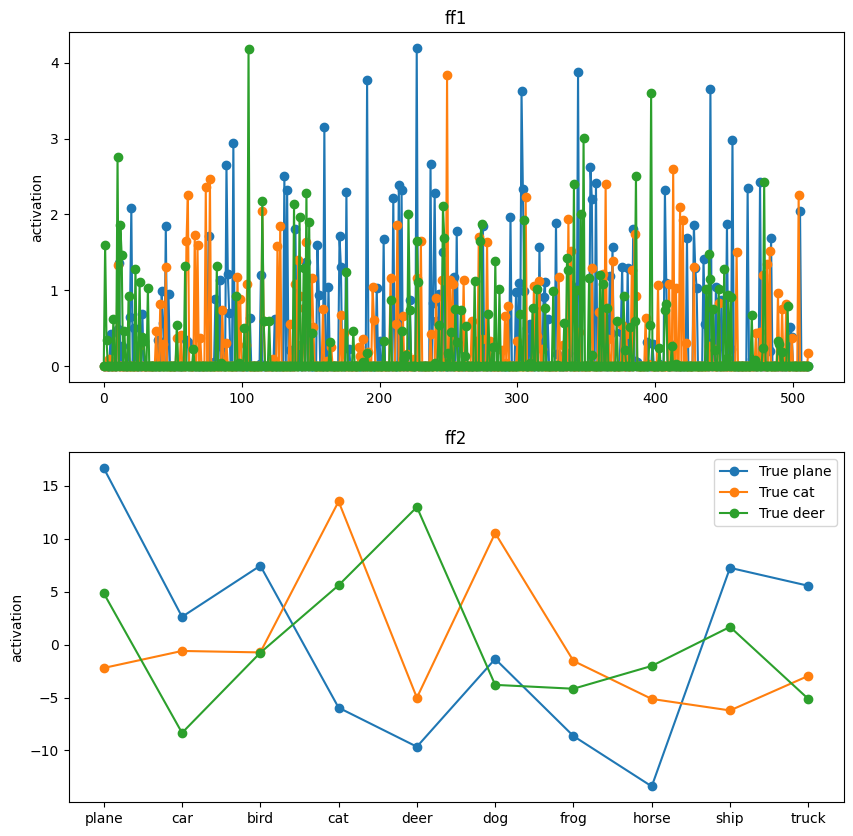

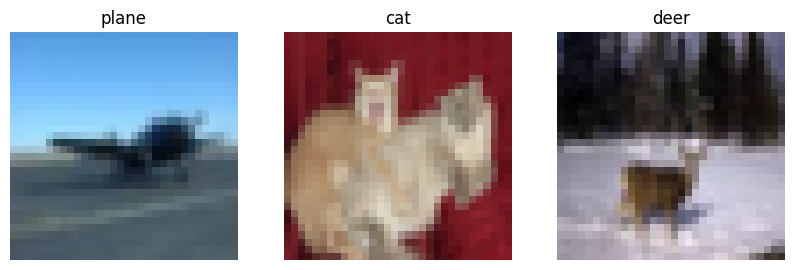

In [ ]:
import matplotlib.pyplot as plt
from collections import OrderedDict

class NetworkVisualization:
    """Renders all feedforward layers
    Sources:
        https://blog.paperspace.com/pytorch-hooks-gradient-clipping-debugging/#:~:text=PyTorch%20provides%20two%20types%20of%20hooks.&text=A%20forward%20hook%20is%20executed,backward%20functions%20of%20an%20Autograd.
    """
    def __init__(self, model, obs_modules):
        self.model = model
        self.layers = OrderedDict()
        for name, layer in self.model._modules.items():
            if name in obs_modules:
                layer.register_forward_hook(self.factory_hook(name))

    def factory_hook(self, name):
        def forward_hook(module, input, output):
            self.layers[name] = output        
        return forward_hook
    def __call__(self, sample):
        output = self.model(sample)
        self.render()
    
    def render(self):
        nLayers = len(self.layers)
        fig, axs = plt.subplots(nLayers, 1, figsize=(10,10))
        for ax, (name, data) in zip(axs, self.layers.items()):
            data = data.detach()
            x_axis = torch.arange(len(data[0]))
            for sample in data:
                ax.plot(x_axis, sample,'-o')
            ax.set_title(name)
            ax.set_ylabel('activation')
        ax.set_xticks(x_axis, labels=CLASS_NAMES)
        
  

plot = NetworkVisualization(model_1, ['ff1', 'ff2'])
nSamples = 3

train_loader = DataLoader(train_set, batch_size=nSamples, shuffle=True, num_workers=2)
sample_img, sample_tgt = next(iter(train_loader))

plot(sample_img[0:nSamples])
plt.legend([f"True {CLASS_NAMES[sample]}" for sample in sample_tgt[:nSamples]])

plt.figure(figsize=(10,10))
for n in range(nSamples):
    ax = plt.subplot(1,nSamples,n+1)
    img = sample_img[n] / 2 + 0.5     # unnormalize
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(CLASS_NAMES[sample_tgt[n]])
    plt.axis("off")
plt.pause(0.1)